In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, roc_curve, auc

# Preprocessing

Start with handling randomness in data sets. Experimentation requires consistency across experiments for model selection and tuning. I did not originally do this making performance evaluation really hard. Lesson learned.
Where randomness occurs:
1. splitting out train/test/testing sets using sklearn train_test_split
2. calling the data loader when shuffle = TRUE, since each run will randomly shuffle samples
3. data augmentation pipelines that include random augmentation methods (Random horizontal flip/Random rotation etc...)
4. model weight initialization - PyTorch randomly assigns initial weights

In [2]:
# set seed - (will require modification to run in Google Colab since gpu is CUDA)
import random

def set_seed(seed):
    random.seed(seed)  # Set seed for Python random module
    np.random.seed(seed)  # Set seed for NumPy
    torch.manual_seed(seed)  # Set seed for running PyTorch on CPU, GPU, MPS
# Set the seed
set_seed(1)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") # For running on M3 processor - !change for running on colab

In [3]:
annotations = pd.read_csv('annotations.csv')
images_folder = 'Images/Images/images'

In [4]:
import os
file_paths = os.listdir(images_folder)

# Create a dictionary mapping file names to their full paths
file_dict = {file: os.path.join(images_folder, file) for file in file_paths}

#print(file_dict)
# Use the dictionary to update the DataFrame
annotations['image_paths'] = annotations['Image Name'].map(file_dict)

1. Encode labels
2. Split out training and testing
3. Visulaize label/agreement distributions, images
4. Edits: 
 * Make adjustments according to feedback and paper - filter training data according to agreement (remove difficult to classify images) - this does not significantly change performance - removing 4/7 slight improvement
 * Remove do not include a third validation set (use only training and test sets to increase training set size)
 * Use base ResNet18, adjust learning rate decay to 0.98
NOTE: Model performance was really bad using what they layed out in the paper so I must be missing something. Overal I got the best performance with the full dataset and ResNet18 model with dropout and learning rate decay.

Remove difficult to classify images - Defined as images classified as SSA with number of annotators who select SSA = 4 and images classified as HP with number of annotators classified as SSA = 3 

In [5]:
annotations.head(10)

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,image_paths
0,MHIST_aaa.png,SSA,6,train,Images/Images/images/MHIST_aaa.png
1,MHIST_aab.png,HP,0,train,Images/Images/images/MHIST_aab.png
2,MHIST_aac.png,SSA,5,train,Images/Images/images/MHIST_aac.png
3,MHIST_aae.png,HP,1,train,Images/Images/images/MHIST_aae.png
4,MHIST_aaf.png,SSA,5,train,Images/Images/images/MHIST_aaf.png
5,MHIST_aag.png,HP,2,test,Images/Images/images/MHIST_aag.png
6,MHIST_aah.png,HP,2,test,Images/Images/images/MHIST_aah.png
7,MHIST_aai.png,HP,3,train,Images/Images/images/MHIST_aai.png
8,MHIST_aaj.png,HP,0,train,Images/Images/images/MHIST_aaj.png
9,MHIST_aak.png,HP,2,train,Images/Images/images/MHIST_aak.png


In [6]:
annotations.loc[annotations['Number of Annotators who Selected SSA (Out of 7)']==4]

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,image_paths
16,MHIST_aas.png,SSA,4,train,Images/Images/images/MHIST_aas.png
28,MHIST_abh.png,SSA,4,train,Images/Images/images/MHIST_abh.png
47,MHIST_ace.png,SSA,4,train,Images/Images/images/MHIST_ace.png
48,MHIST_acf.png,SSA,4,train,Images/Images/images/MHIST_acf.png
63,MHIST_acv.png,SSA,4,train,Images/Images/images/MHIST_acv.png
...,...,...,...,...,...
2565,MHIST_dxo.png,SSA,4,test,Images/Images/images/MHIST_dxo.png
2584,MHIST_eke.png,SSA,4,test,Images/Images/images/MHIST_eke.png
2586,MHIST_elf.png,SSA,4,train,Images/Images/images/MHIST_elf.png
2597,MHIST_cpr.png,SSA,4,test,Images/Images/images/MHIST_cpr.png


In [7]:
annotations['Number of Annotators who Selected SSA (Out of 7)'].value_counts()

Number of Annotators who Selected SSA (Out of 7)
0    723
1    705
2    426
7    356
3    308
6    250
4    216
5    168
Name: count, dtype: int64

Removed samples where annotator agreement was 3 or 4

In [8]:
hard_images_removed = annotations.loc[~(annotations['Number of Annotators who Selected SSA (Out of 7)']==4)].copy()
hard_images_removed['Number of Annotators who Selected SSA (Out of 7)'].value_counts()

Number of Annotators who Selected SSA (Out of 7)
0    723
1    705
2    426
7    356
3    308
6    250
5    168
Name: count, dtype: int64

In [9]:
# Unbalanced Data Set
data_set = hard_images_removed
data_set = data_set.reset_index(drop=True) #For some reason always do this to modified DFs even if they have the right indices - filtering DFs messes them up
data_set['category'] = data_set['Majority Vote Label'].apply(lambda x: 1 if x == 'SSA' else 0)
data_set['category'].value_counts()

category
0    2162
1     774
Name: count, dtype: int64

In [10]:
data_set.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,image_paths,category
0,MHIST_aaa.png,SSA,6,train,Images/Images/images/MHIST_aaa.png,1
1,MHIST_aab.png,HP,0,train,Images/Images/images/MHIST_aab.png,0
2,MHIST_aac.png,SSA,5,train,Images/Images/images/MHIST_aac.png,1
3,MHIST_aae.png,HP,1,train,Images/Images/images/MHIST_aae.png,0
4,MHIST_aaf.png,SSA,5,train,Images/Images/images/MHIST_aaf.png,1


In [11]:
# Split out training and testing according to data set
train_data = data_set[data_set['Partition'] == 'train']
test_data = data_set[data_set['Partition'] == 'test']
# reset the index
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

#test_data.head()
train_data.head()

,Image Name,Majority Vote Label,Number of Annotators who Selected SSA (Out of 7),Partition,image_paths,category
0,MHIST_aaa.png,SSA,6,train,Images/Images/images/MHIST_aaa.png,1
1,MHIST_aab.png,HP,0,train,Images/Images/images/MHIST_aab.png,0
2,MHIST_aac.png,SSA,5,train,Images/Images/images/MHIST_aac.png,1
3,MHIST_aae.png,HP,1,train,Images/Images/images/MHIST_aae.png,0
4,MHIST_aaf.png,SSA,5,train,Images/Images/images/MHIST_aaf.png,1


In [12]:
# # Split out test set:
# from sklearn.model_selection import train_test_split

# train_data, val_data = train_test_split(train_data, test_size=0.1, shuffle=True)

# train_data = train_data.reset_index(drop=True)
# val_data = val_data.reset_index(drop=True)

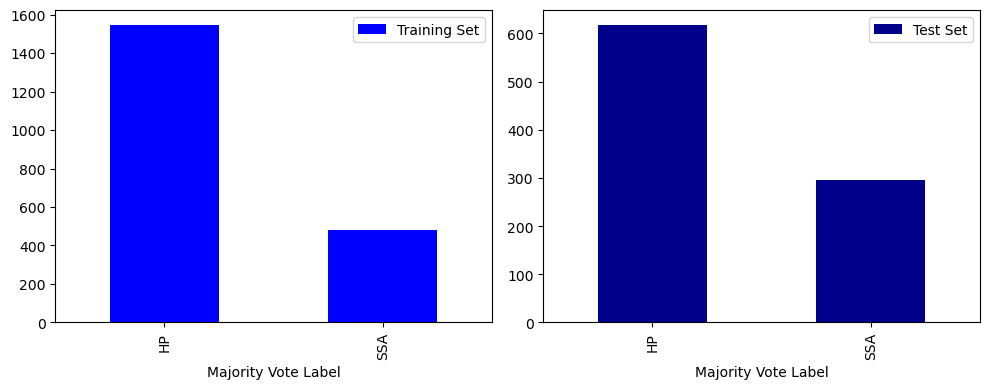

In [13]:
# Look at label distribution in each set
fig, axes = plt.subplots(1, 2, figsize=(10, 4)) 

train_data['Majority Vote Label'].value_counts().plot(kind='bar', ax=axes[0], label='Training Set', color='blue')
test_data['Majority Vote Label'].value_counts().plot(kind='bar', ax=axes[1], label='Test Set', color='darkblue')

axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()

determine class weights as a possible solution for class imbalance

In [14]:
# ## ClassWeights - for potential balancing
# class_counts = [2162, 990]
# class_weights = [len(data_set['category']) / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))]
# class_weights
# class_counts = data_set['category'].value_counts()
# class_counts
# #class_counts.iloc[0]

### DataSet Class

In [15]:
# DataSet Class
import skimage
class MHISTDataset(Dataset):
  def __init__(self, data_set_df, transform=None, target_transform=None):
    self.img_paths = data_set_df['image_paths']
    self.img_labels = data_set_df['category']
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = self.img_paths[idx]
    image = skimage.io.imread(img_path)
    label = self.img_labels[idx]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    output = {"image": image, "label": label, "img_path": img_path}
    return output

In [16]:
labels = []
image_paths = []

data_loader = DataLoader(MHISTDataset(data_set), batch_size = 16, shuffle = True)
for i, batch in enumerate(data_loader):
  images = batch['image']
  labels += batch['label']

In [17]:
print(f'Image shape: {images[0].shape}')

Image shape: torch.Size([224, 224, 3])


Look at the images

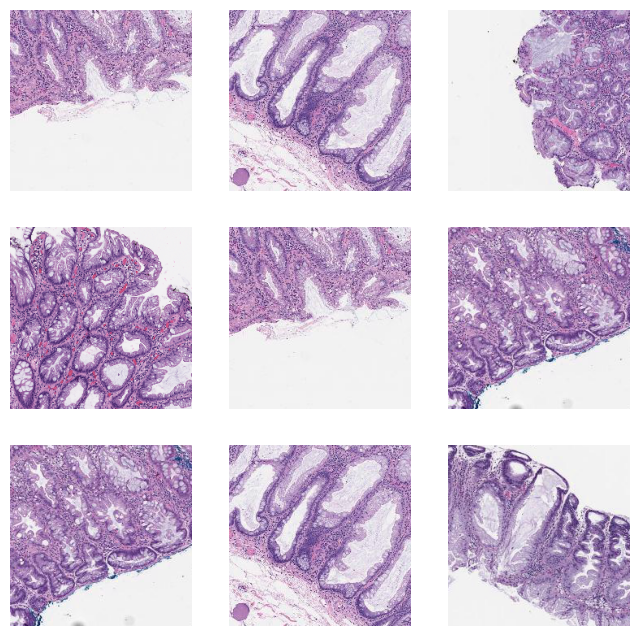

In [18]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item() # grab a random index
    image = images[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(image.squeeze())
plt.show()

## Augmentation

Calculate mean and standard deviation of images for normalization in scratch models. For Pytorch models original mean and standard deviation models were trained on will be used to ensure better performance.

In [19]:
# Mean and Standard Deviation for normalizations in scratch models
mean_sum = np.zeros(3)
std_sum = np.zeros(3)
num_images = 0

temp_dataset = MHISTDataset(data_set, transform=transforms.ToTensor())

# Iterate through the dataset
for idx in range(len(temp_dataset)):
    image_tensor = temp_dataset[idx]['image']  # Get image 
    mean_sum += np.mean(image_tensor.numpy(), axis=(1, 2))  # Calculate mean along height and width
    std_sum += np.std(image_tensor.numpy(), axis=(1, 2))   # Calculate std along height and width
    num_images += 1

# Calculate mean and standard deviation
mean = mean_sum / num_images
std = std_sum / num_images

print("Mean:", mean)
print("Standard Deviation:", std)

Mean: [0.73925847 0.65237455 0.77723166]
Standard Deviation: [0.18744938 0.22867652 0.16212841]


### Transformation pipelines for augmentations for training scratch models

In [20]:
# Basic Transforms for scratch models using Pillow
MHISTtransforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.74, 0.65, 0.78), (0.19, 0.23, 0.16))
])

# Transformations with Horizontal Flip and Rotation
transforms_exp1 = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),  
    transforms.Normalize((0.74, 0.65, 0.78), (0.19, 0.23, 0.16))
])

# Transformations with Color Jitter
transforms_exp2 = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),  
    transforms.Normalize((0.74, 0.65, 0.78), (0.19, 0.23, 0.16))
])

# Transformations with Adjust Sharpness
transforms_exp3 = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.RandomAdjustSharpness(0.5),
    transforms.ToTensor(), 
    transforms.Normalize((0.74, 0.65, 0.78), (0.19, 0.23, 0.16))
])

### Transformation pipelines for augmentations for training pyTorch models

In [21]:
# Resnet, ViT_B_16 Transforms based on ImageNet dataset

MHISTtransformsPyTorchModels = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
# Transformations with Horizontal Flip and Rotation
transforms_PyTorchModels_exp1 = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),  
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Transformations with Color Jitter
transforms_PyTorchModels_exp2 = transforms.Compose([
    transforms.ToPILImage(), 
    transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),  
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Transformations with Adjust Sharpness
transforms_PyTorchModels_exp3 = transforms.Compose([
    transforms.ToPILImage(),  
    transforms.RandomAdjustSharpness(0.2),
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


### Visualize transformations

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


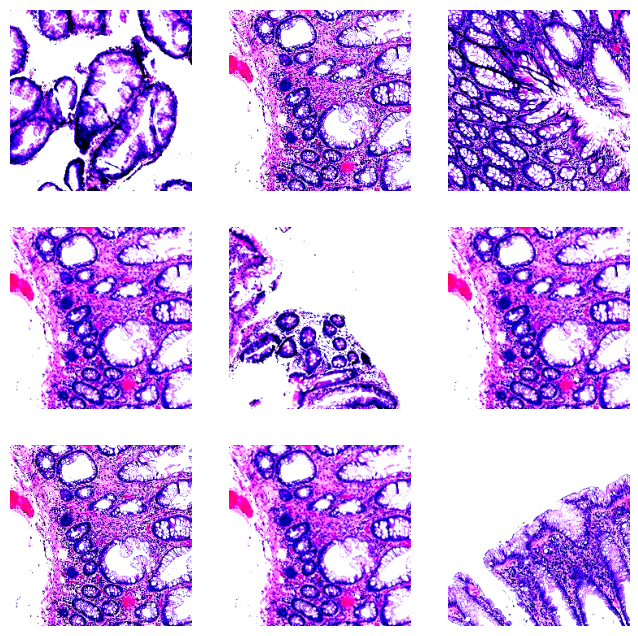

In [22]:
lookAtTransformations_dataset = MHISTDataset(data_set, transform=transforms_PyTorchModels_exp3)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images), size=(1,)).item()
    sample = lookAtTransformations_dataset[sample_idx]
    image = sample['image'] 
    image = image.permute(1, 2, 0)  # Change shape from (C, H, W) to (H, W, C) 
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(image.squeeze())  
plt.show()

### Balancing
Over/Undersampling

In [23]:
#Balancing using imblearn 
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

In [24]:
X = train_data[['image_paths', 'Majority Vote Label']].values  
y = train_data['category']

# Under-sampling
rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_resample(X, y)

# Over-sampling
ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X, y)

# Reconstruct the DataFrame after resampling
train_data_undersampled = pd.DataFrame({
    'image_paths': X_rus[:, 0], 
    'Majority Vote Label': X_rus[:, 1],  
    'category': y_rus
})

train_data_oversampled = pd.DataFrame({
    'image_paths': X_ros[:, 0], 
    'Majority Vote Label': X_ros[:, 1],  
    'category': y_ros
})


In [25]:
print(train_data_oversampled['Majority Vote Label'].value_counts())
print(train_data_undersampled['Majority Vote Label'].value_counts())

Majority Vote Label
SSA    1545
HP     1545
Name: count, dtype: int64
Majority Vote Label
HP     479
SSA    479
Name: count, dtype: int64


# Training

In [26]:
# Training, Testing, test Loaders (Unbalanced)
train_loader = DataLoader(MHISTDataset(train_data, transform=MHISTtransformsPyTorchModels), batch_size=32, shuffle=True)
test_loader = DataLoader(MHISTDataset(test_data, transform = MHISTtransformsPyTorchModels), batch_size=16, shuffle=False)
#val_loader = DataLoader(MHISTDataset(val_data, transform = MHISTtransforms), batch_size=32, shuffle=False)

In [27]:
# Balanced Loaders
oversampled_train_loader = DataLoader(MHISTDataset(train_data_oversampled, transform=transforms_PyTorchModels_exp1), batch_size=64, shuffle = True)
undersampled_train_loader = DataLoader(MHISTDataset(train_data_undersampled, transform=MHISTtransforms), batch_size=64, shuffle = True)

# Models

### Scratch Models

Fully Connected Models with varying number of nodes and hidden layers

In [28]:
class SimpleFCN(nn.Module):
    def __init__(self):
        super(SimpleFCN, self).__init__()

        # Define fully connected layers
        self.fc1 = nn.Linear(3 * 224 * 224, 512)  # Input layer
        self.fc2 = nn.Linear(512, 128)            # Hidden layer
        self.fc3 = nn.Linear(128, 2)              # Output layer

        # Define the ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten the input
        x = x.view(-1, 3 * 224 * 224)

        # Forward pass through fully connected layers with ReLU activations
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        # Output layer (no activation, assuming CrossEntropyLoss is used)
        x = self.fc3(x)

        return x

In [29]:
class ComplexFCN(nn.Module):
    def __init__(self):
        super(ComplexFCN, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(224*224*3, 1024)  # Input layer
        self.fc2 = nn.Linear(1024, 512)        # Hidden layers
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)            # Output layer

        # Define ReLU activation as part of the architecture
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten the input image into a vector of size (batch_size, 224*224*3)
        x = x.view(-1, 224*224*3)

        # Forward pass through fully connected layers with ReLU activations
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.relu(self.fc4(x))

        # Output layer (no activation here, assuming CrossEntropyLoss is used)
        x = self.fc5(x)

        return x

Fully connected model with dropout

In [30]:
class DropoutFCN(nn.Module):
    def __init__(self):
        super(DropoutFCN, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(224*224*3, 1024)  # Increased neurons
        self.fc2 = nn.Linear(1024, 512)        # Added another layer
        self.fc3 = nn.Linear(512, 128)         # Increased neurons
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 2)

        # Dropout layers for regularization
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)

        # ReLU activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten the input image into a vector of size (batch_size, 224*224*3)
        x = x.view(-1, 224*224*3)

        # Forward pass through fully connected layers with ReLU activations and Dropout
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)

        x = self.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.relu(self.fc3(x))
        x = self.dropout3(x)

        x = self.relu(self.fc4(x))

        # Output layer (no activation, assuming CrossEntropyLoss is used)
        x = self.fc5(x)

        return x

Fully connected model with batch normalization

In [31]:
class BatchNormFCN(nn.Module):
    def __init__(self):
        super(BatchNormFCN, self).__init__()

        # Fully connected layers
        self.fc1 = nn.Linear(224*224*3, 1024)  # Input layer (image flattened to 224*224*3)
        self.bn1 = nn.BatchNorm1d(1024)        # Batch normalization for the first layer

        self.fc2 = nn.Linear(1024, 512)        # Second layer
        self.bn2 = nn.BatchNorm1d(512)         # Batch normalization for the second layer

        self.fc3 = nn.Linear(512, 128)         # Third layer
        self.bn3 = nn.BatchNorm1d(128)         # Batch normalization for the third layer

        self.fc4 = nn.Linear(128, 64)          # Fourth layer (no batch norm needed here)
        self.fc5 = nn.Linear(64, 2)            # Output layer

        # Define the ReLU activation function as part of the architecture
        self.relu = nn.ReLU()

    def forward(self, x):
        # Flatten the input image to a vector of size (batch_size, 224*224*3)
        x = x.view(-1, 224*224*3)

        # Forward pass through fully connected layers with batch normalization and ReLU activations
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.relu(self.fc4(x))

        # Output layer (no activation here, as it's typically handled by CrossEntropyLoss)
        x = self.fc5(x)

        return x

Convolutional Models

In [32]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # Fully connected layers
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

        # Define ReLU activations as layers
        self.relu = nn.ReLU()

    def forward(self, x):
        # Convolutional layers with ReLU and pooling
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Flatten the output from conv layers
        x = torch.flatten(x, 1)

        # Fully connected layers with ReLU activations
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))

        # Output layer (no activation here, assuming CrossEntropyLoss will be used)
        x = self.fc3(x)
        return x

In [33]:
class CNN_Modified1(nn.Module):
    def __init__(self):
        super(CNN_Modified1, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # Increased channels, reduced kernel size
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 256)  # Adjusted for the output size of the conv layers
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Activation functions
        self.relu = nn.ReLU()  # Define ReLU as a layer

    def forward(self, x):
        # Forward pass through conv layers, batch norm, ReLU, and pooling
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))

        # Flatten the output from the conv layers
        x = torch.flatten(x, 1)

        # Fully connected layers with activation and dropout
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))

        # Output layer (no activation, assuming you're using CrossEntropyLoss which includes softmax internally)
        x = self.fc3(x)
        return x

### Pytorch Models

https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18
https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.resnet50
https://pytorch.org/vision/stable/models/generated/torchvision.models.vit_b_16.html#torchvision.models.ViT_B_16_Weights

In [34]:
from torchvision.models import ResNet18_Weights, ResNet50_Weights
# Pre-Trained weights
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet50 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
# Change architecture
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 2)

In [35]:
# ResNets with Dropout
resnet18_dropout = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Modify the fully connected layer to include Dropout
resnet18_dropout.fc = nn.Sequential(
    nn.Linear(resnet18_dropout.fc.in_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.6),  
    nn.Linear(512, 2)  
)

In [36]:
# ResNets with Dropout
resnet50_dropout = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Modify the fully connected layer to include Dropout
resnet50_dropout.fc = nn.Sequential(
    nn.Linear(resnet50_dropout.fc.in_features, 512),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.7),  
    nn.Linear(512, 2)  
)

In [37]:
# Transformers
from torchvision.models import ViT_B_16_Weights 
vit = models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT)
vit.heads.head = nn.Linear(vit.heads.head.in_features, 2)

# Training

In [38]:

# Store metrics for final ROC 
global_val_labels = []
global_val_probs = []

def validate(model, test_loader, criterion, device):
    model.eval()  
    val_epoch_loss = 0
    val_all_preds = []
    val_all_labels = []
    val_all_probs = []  # To store predicted probabilities for ROC values during training

    with torch.no_grad():  
        for batch in test_loader:
            inputs = batch['image'].type(torch.FloatTensor).to(device)
            labels = batch['label'].type(torch.LongTensor).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_epoch_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_all_preds.extend(predicted.cpu().numpy())
            val_all_labels.extend(labels.cpu().numpy())

            # Get probabilities for the positive class
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            val_all_probs.extend(probs)

    # final ROC/AUC calculation
    global_val_labels.extend(val_all_labels)
    global_val_probs.extend(val_all_probs)

    # Calculate test metrics
    loss_avg = val_epoch_loss / len(test_loader)
    f1 = f1_score(val_all_labels, val_all_preds)
    precision = precision_score(val_all_labels, val_all_preds)
    recall = recall_score(val_all_labels, val_all_preds)
    accuracy = accuracy_score(val_all_labels, val_all_preds)

    tn, fp, fn, tp = confusion_matrix(val_all_labels, val_all_preds).ravel()
    specificity = tn / (tn + fp)

    # Calculate AUC for the current epoch
    fpr, tpr, thresholds = roc_curve(val_all_labels, val_all_probs)
    roc_auc = auc(fpr, tpr)

    return loss_avg, f1, precision, recall, specificity, accuracy, roc_auc

def plot_final_roc_auc():
    # Calculate ROC Curve and AUC
    fpr, tpr, thresholds = roc_curve(global_val_labels, global_val_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkred', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Final Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    print(f"Final AUC: {roc_auc:.4f}")

def train_and_validate(model, test_loader, criterion, optimizer, epochs, device):
    train_loss = []
    train_f1 = []
    train_precision = []
    train_recall = []
    train_specificity = []
    train_accuracy = []

    val_loss = []
    val_f1 = []
    val_precision = []
    val_recall = []
    val_specificity = []
    val_accuracy = []
    val_auc = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        all_preds = []
        all_labels = []

        for batch in train_loader:
            inputs = batch['image'].type(torch.FloatTensor).to(device)
            labels = batch['label'].type(torch.LongTensor).to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Calculate and store metrics for training
        train_loss.append(epoch_loss / len(train_loader))
        train_f1.append(f1_score(all_labels, all_preds))
        train_precision.append(precision_score(all_labels, all_preds))
        train_recall.append(recall_score(all_labels, all_preds))
        train_accuracy.append(accuracy_score(all_labels, all_preds))

        tn, fp, fn, tp = confusion_matrix(all_labels, all_preds).ravel()
        train_specificity.append(tn / (tn + fp))

        # test phase with ROC/AUC calculation
        val_metrics = validate(model, test_loader, criterion, device=device)
        val_loss.append(val_metrics[0])
        val_f1.append(val_metrics[1])
        val_precision.append(val_metrics[2])
        val_recall.append(val_metrics[3])
        val_specificity.append(val_metrics[4])
        val_accuracy.append(val_metrics[5])
        val_auc.append(val_metrics[6])

        # Print metrics for the current epoch
        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'  Training   | Loss: {train_loss[-1]:.4f}, F1: {train_f1[-1]:.4f}, Precision: {train_precision[-1]:.4f}, Recall: {train_recall[-1]:.4f}, Specificity: {train_specificity[-1]:.4f}, Accuracy: {train_accuracy[-1]:.4f}')
        print(f'  test | Loss: {val_loss[-1]:.4f}, F1: {val_f1[-1]:.4f}, Precision: {val_precision[-1]:.4f}, Recall: {val_recall[-1]:.4f}, Specificity: {val_specificity[-1]:.4f}, Accuracy: {val_accuracy[-1]:.4f}, AUC: {val_auc[-1]:.4f}')

    # After training is complete, plot the final ROC/AUC
    plot_final_roc_auc()

    return {
        "train_loss": train_loss,
        "train_f1": train_f1,
        "train_precision": train_precision,
        "train_recall": train_recall,
        "train_specificity": train_specificity,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_f1": val_f1,
        "val_precision": val_precision,
        "val_recall": val_recall,
        "val_specificity": val_specificity,
        "val_accuracy": val_accuracy,
        "val_auc": val_auc
    }

### Experimentation:
Instantiate and Run Models

In [39]:
model = resnet18.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.98)
epochs = 20
#optimizer_2 = torch.optim.Adam(model.parameters(), lr = 0.01)

In [40]:
# weighted_criterion = nn.CrossEntropyLoss(weights = class_weights)

/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [1/20]
  Training   | Loss: 0.5071, F1: 0.2735, Precision: 0.4627, Recall: 0.1942, Specificity: 0.9301, Accuracy: 0.7559
  test | Loss: 0.6366, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.5348


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/20]
  Training   | Loss: 0.5303, F1: 0.0631, Precision: 0.5714, Recall: 0.0334, Specificity: 0.9922, Accuracy: 0.7653
  test | Loss: 0.6411, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.4219


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [3/20]
  Training   | Loss: 0.5399, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 0.9987, Accuracy: 0.7624
  test | Loss: 0.6365, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.5547


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [4/20]
  Training   | Loss: 0.5604, F1: 0.0082, Precision: 0.1818, Recall: 0.0042, Specificity: 0.9942, Accuracy: 0.7599
  test | Loss: 1.2143, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.5567


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [5/20]
  Training   | Loss: 0.5445, F1: 0.0041, Precision: 0.3333, Recall: 0.0021, Specificity: 0.9987, Accuracy: 0.7628
  test | Loss: 0.6301, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.5946


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [6/20]
  Training   | Loss: 0.5691, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 0.9994, Accuracy: 0.7628
  test | Loss: 0.6436, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.6259


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [7/20]
  Training   | Loss: 0.5560, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.7633
  test | Loss: 0.6643, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.6003


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [8/20]
  Training   | Loss: 0.5531, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.7633
  test | Loss: 0.6491, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.4269


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [9/20]
  Training   | Loss: 0.5303, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.7633
  test | Loss: 0.6412, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.4460


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [10/20]
  Training   | Loss: 0.5515, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.7633
  test | Loss: 0.6331, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.4490


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [11/20]
  Training   | Loss: 0.5353, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.7633
  test | Loss: 0.6299, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.3760


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [12/20]
  Training   | Loss: 0.5186, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.7633
  test | Loss: 0.6139, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.6041


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [13/20]
  Training   | Loss: 0.5354, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.7633
  test | Loss: 0.6434, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.4047


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [14/20]
  Training   | Loss: 0.5288, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.7633
  test | Loss: 0.6923, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.6696


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [15/20]
  Training   | Loss: 0.4988, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.7633
  test | Loss: 0.6803, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.6836


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [16/20]
  Training   | Loss: 0.5047, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.7633
  test | Loss: 0.6193, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.6083


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [17/20]
  Training   | Loss: 0.5042, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.7633
  test | Loss: 0.8892, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.6074


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [18/20]
  Training   | Loss: 0.5261, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.7633
  test | Loss: 0.6759, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.6766


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [19/20]
  Training   | Loss: 0.5172, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.7633
  test | Loss: 0.9615, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.5000


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [20/20]
  Training   | Loss: 0.5087, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.7633
  test | Loss: 0.9904, F1: 0.0000, Precision: 0.0000, Recall: 0.0000, Specificity: 1.0000, Accuracy: 0.6765, AUC: 0.4806


/Users/clairevans/Documents/ML/mhist_project/env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


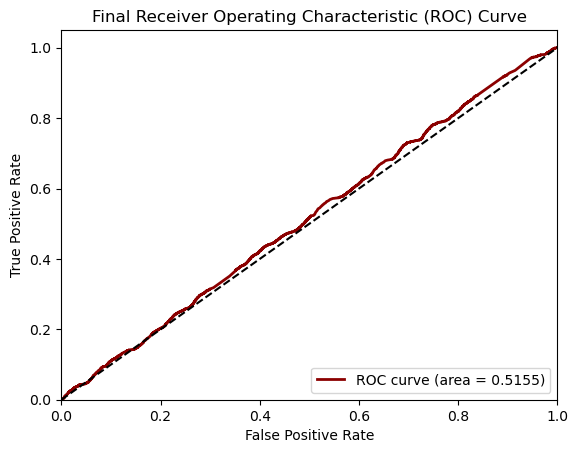

Final AUC: 0.5155


In [41]:
results = train_and_validate(model, test_loader, criterion, optimizer, epochs, device)

## Plot

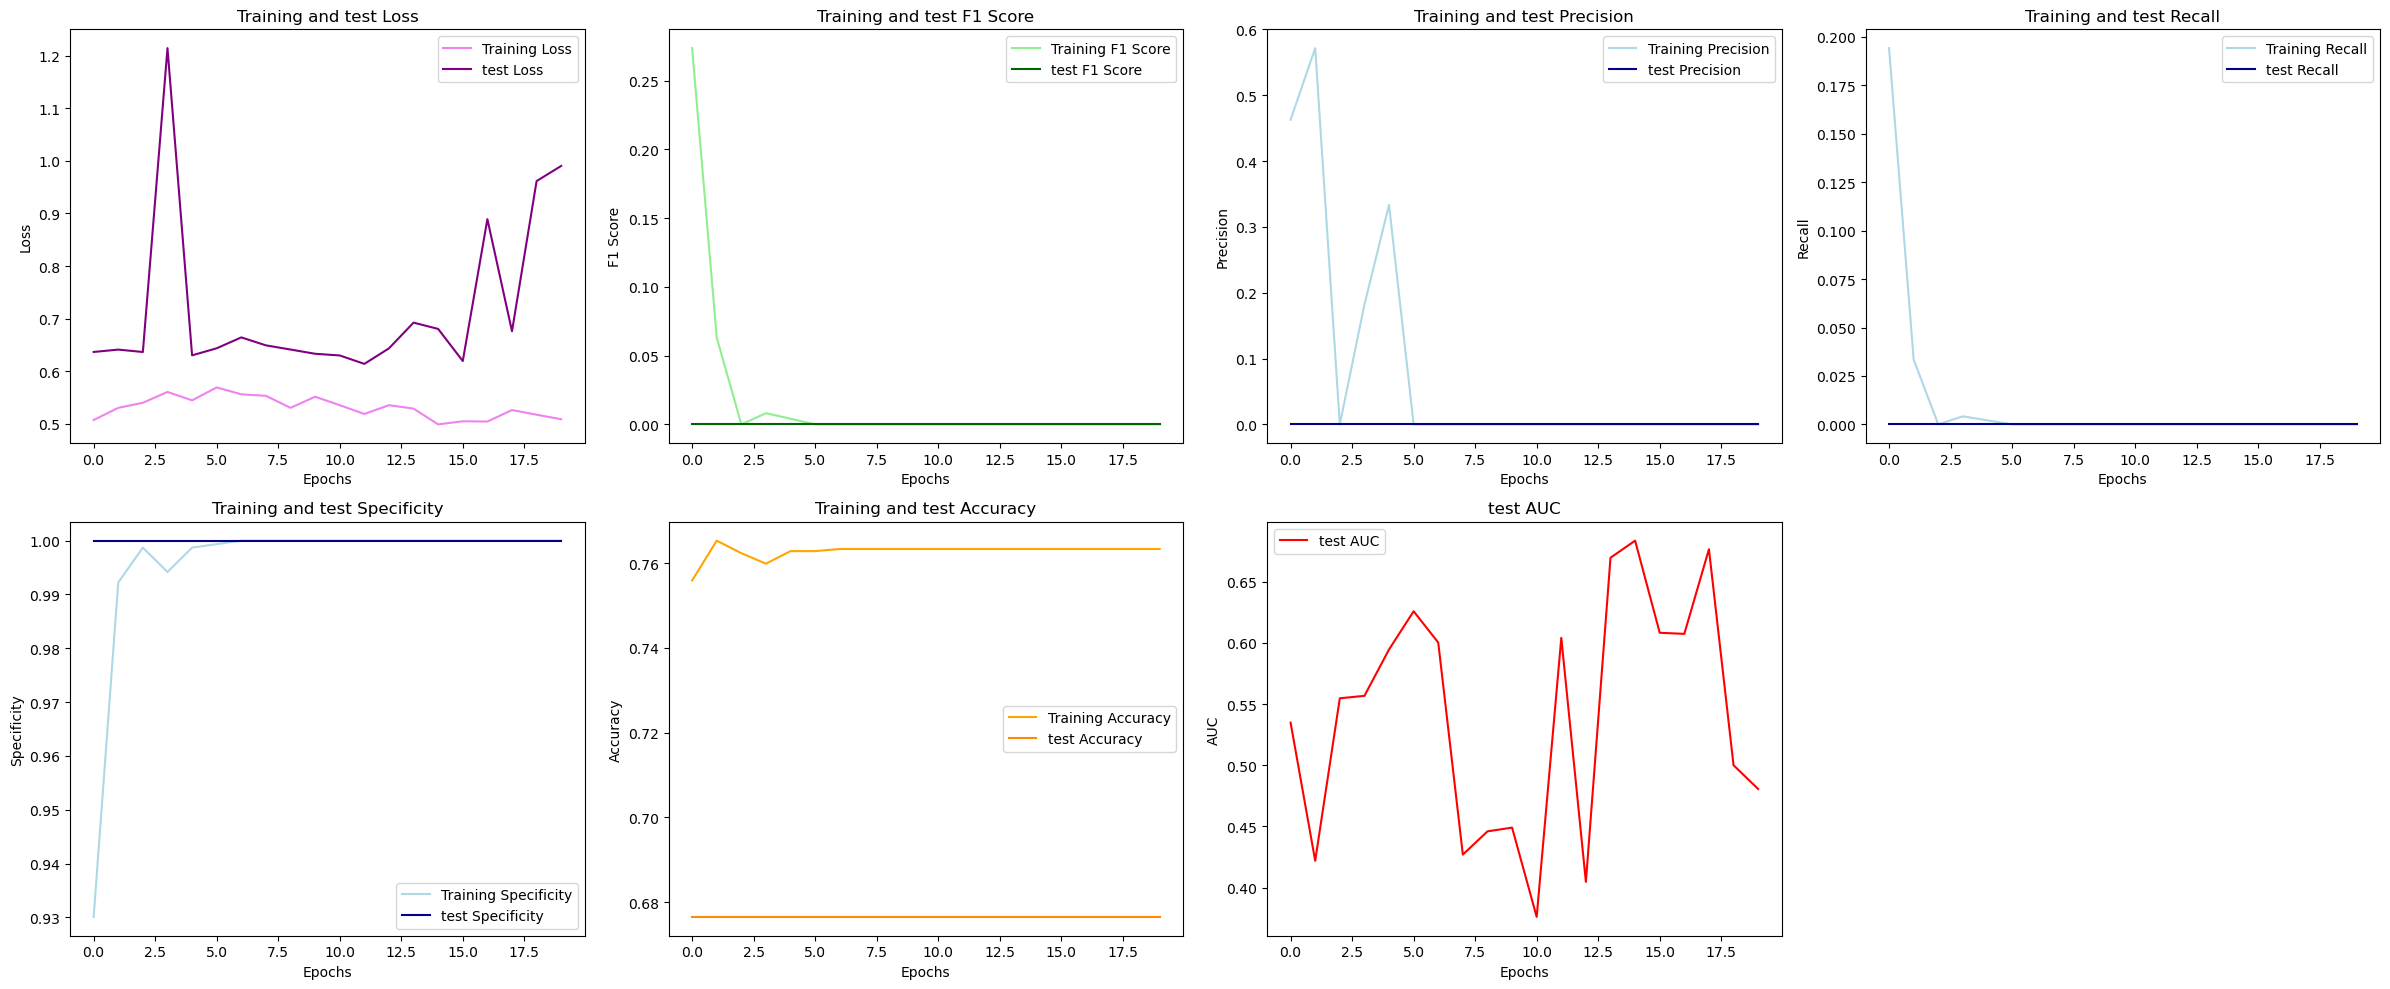

In [42]:
train_loss = results['train_loss']
val_loss = results['val_loss']
train_f1 = results['train_f1']
val_f1 = results['val_f1']
train_precision = results['train_precision']
val_precision = results['val_precision']
train_recall = results['train_recall']
val_recall = results['val_recall']
train_specificity = results['train_specificity']
val_specificity = results['val_specificity']
train_accuracy = results['train_accuracy']
val_accuracy = results['val_accuracy']
val_auc = results['val_auc']


fig, axes = plt.subplots(2, 4, figsize=(24, 10)) 

# Plot Loss
axes[0, 0].plot(train_loss, label='Training Loss', color='violet')
axes[0, 0].plot(val_loss, label='test Loss', color='purple')
axes[0, 0].set_title('Training and test Loss')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# Plot F1 score
axes[0, 1].plot(train_f1, label='Training F1 Score', color='lightgreen')
axes[0, 1].plot(val_f1, label='test F1 Score', color='darkgreen')
axes[0, 1].set_title('Training and test F1 Score')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('F1 Score')
axes[0, 1].legend()

# Plot Precision
axes[0, 2].plot(train_precision, label='Training Precision', color='lightblue')
axes[0, 2].plot(val_precision, label='test Precision', color='darkblue')
axes[0, 2].set_title('Training and test Precision')
axes[0, 2].set_xlabel('Epochs')
axes[0, 2].set_ylabel('Precision')
axes[0, 2].legend()

# Plot Recall
axes[0, 3].plot(train_recall, label='Training Recall', color='lightblue')
axes[0, 3].plot(val_recall, label='test Recall', color='darkblue')
axes[0, 3].set_title('Training and test Recall')
axes[0, 3].set_xlabel('Epochs')
axes[0, 3].set_ylabel('Recall')
axes[0, 3].legend()

# Plot Specificity
axes[1, 0].plot(train_specificity, label='Training Specificity', color='lightblue')
axes[1, 0].plot(val_specificity, label='test Specificity', color='darkblue')
axes[1, 0].set_title('Training and test Specificity')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Specificity')
axes[1, 0].legend()

# Plot Accuracy
axes[1, 1].plot(train_accuracy, label='Training Accuracy', color='orange')
axes[1, 1].plot(val_accuracy, label='test Accuracy', color='darkorange')
axes[1, 1].set_title('Training and test Accuracy')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

# Plot AUC
axes[1, 2].plot(val_auc, label='test AUC', color='red')
axes[1, 2].set_title('test AUC')
axes[1, 2].set_xlabel('Epochs')
axes[1, 2].set_ylabel('AUC')
axes[1, 2].legend()

# Hide the last empty subplot if not used
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

In [43]:
def evaluate_model_on_test_set(model, test_loader, device):
    model.eval()  # Ensure the model is in evaluation mode
    all_labels = []
    all_probs = []
    all_preds = []

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['image'].type(torch.FloatTensor).to(device)
            labels = batch['label'].type(torch.LongTensor).to(device)

            # Get model outputs and apply softmax to get probabilities
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Probabilities for the positive class
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Compute accuracy
    accuracy = accuracy_score(all_labels, all_preds)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guess
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Test Set')
    plt.legend(loc="lower right")
    plt.show()

    print(f'Test Accuracy: {accuracy:.4f}')
    return roc_auc, accuracy
